# EMG Data Processing Pipeline
## Complete Pipeline Analysis for BMEG 457 App

This notebook demonstrates the complete EMG processing pipeline used in the BMEG 457 application, including:
- Data loading from recorded CSV files
- Signal processing (filtering, rectification, envelope detection)
- Feature extraction (RMS, MAV, median frequency)
- Advanced analysis (activation timing, contraction detection, fatigue analysis)
- Visualization and results

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import spectrogram
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import BMEG 457 app modules
import sys
sys.path.append('../')  # Add parent directory to path
from app.processing import filters, features, pipeline
from app.core.config import Config

print("✅ All libraries imported successfully")
print(f"📊 Configuration loaded - Sampling frequency: 2000 Hz")

✅ All libraries imported successfully
📊 Configuration loaded - Sampling frequency: 2000 Hz


## 1. Data Loading and Initial Analysis

In [5]:
# Load the recorded EMG data
data_path = "recording_20251126_162125_knee_new2.csv"
print(f"📂 Loading data from: {data_path}")

# Read CSV file
df = pd.read_csv(data_path)
print(f"✅ Data loaded successfully")
print(f"📊 Data shape: {df.shape}")
print(f"⏱️  Duration: {df.shape[0]/2000:.2f} seconds ({df.shape[0]} samples)")
print(f"🔌 Channels: {df.shape[1]-1} (excluding timestamp)")

# Set up parameters
fs = 2000  # Sampling frequency in Hz
total_samples = len(df)
duration = total_samples / fs
time = np.arange(total_samples) / fs

# Extract channel data (excluding timestamp)
channels_data = df.iloc[:, 1:].values.T  # Shape: (72, samples)
hdsemg_data = channels_data[:64]  # First 64 channels are HDsEMG
aux_data = channels_data[64:]     # Last 8 channels are auxiliary

print(f"🧠 HDsEMG channels: {hdsemg_data.shape}")
print(f"🔧 Auxiliary channels: {aux_data.shape}")
print(f"📈 Data range - Min: {channels_data.min():.0f}, Max: {channels_data.max():.0f}")

# Display first few samples
print("\n📋 First 5 samples of first 8 channels:")
print(df.iloc[:5, :9].to_string())

📂 Loading data from: recording_20251126_162125_knee_new2.csv
✅ Data loaded successfully
📊 Data shape: (146000, 73)
⏱️  Duration: 73.00 seconds (146000 samples)
🔌 Channels: 72 (excluding timestamp)
🧠 HDsEMG channels: (64, 146000)
🔧 Auxiliary channels: (8, 146000)
📈 Data range - Min: -32768, Max: 32767

📋 First 5 samples of first 8 channels:
   Timestamp  Channel_1  Channel_2  Channel_3  Channel_4  Channel_5  Channel_6  Channel_7  Channel_8
0   0.028298         62         89        136        130        123        120        153        143
1   0.028298         37         56         99         89         85         83        115        103
2   0.028298         32         43         51         56         55         48         77         79
3   0.028298         23         37         38         36         30         21         48         51
4   0.028298         23         14         14         -1         -9         -9         12         11
✅ Data loaded successfully
📊 Data shape: (146000, 73

## 2. Signal Processing Pipeline
### Following the exact pipeline used in the BMEG 457 app

In [14]:
# Step 1: Bandpass filtering (20-500 Hz - typical EMG frequency range)
print("🔧 Step 1: Bandpass filtering (20-500 Hz)")
filtered_data = filters.butter_bandpass(hdsemg_data, low=20, high=500, fs=fs, order=4)
print(f"✅ Bandpass filter applied to {filtered_data.shape[0]} channels")

# Step 2: Notch filtering (50/60 Hz - power line interference)
print("\n🔧 Step 2: Notch filtering (50 Hz power line)")
notch_data = filters.notch(filtered_data, freq=50, fs=fs, quality=30)
print(f"✅ Notch filter applied")

# Step 3: Rectification (absolute value)
print("\n🔧 Step 3: Rectification")
rectified_data = filters.rectify(notch_data)
print(f"✅ Signal rectified")

# Step 4: Envelope detection (low-pass filter for smoothing)
print("\n🔧 Step 4: Envelope detection (5 Hz low-pass)")
envelope_data = filters.envelope(rectified_data, fs=fs, cutoff=5.0)
print(f"✅ Envelope extracted")

print(f"\n📊 Processing complete!")
print(f"Original data range: [{hdsemg_data.min():.0f}, {hdsemg_data.max():.0f}]")
print(f"Filtered data range: [{filtered_data.min():.2f}, {filtered_data.max():.2f}]")
print(f"Envelope data range: [{envelope_data.min():.2f}, {envelope_data.max():.2f}]")

🔧 Step 1: Bandpass filtering (20-500 Hz)
✅ Bandpass filter applied to 64 channels

🔧 Step 2: Notch filtering (50 Hz power line)
✅ Notch filter applied

🔧 Step 3: Rectification
✅ Signal rectified

🔧 Step 4: Envelope detection (5 Hz low-pass)
✅ Envelope extracted

📊 Processing complete!
✅ Notch filter applied

🔧 Step 3: Rectification
✅ Signal rectified

🔧 Step 4: Envelope detection (5 Hz low-pass)
✅ Envelope extracted

📊 Processing complete!
Original data range: [-32768, 32767]
Filtered data range: [-35972.69, 33637.93]
Envelope data range: [-866.07, 11226.98]
Original data range: [-32768, 32767]
Filtered data range: [-35972.69, 33637.93]
Envelope data range: [-866.07, 11226.98]


## 3. Simulated Calibration Data
### Since we need baseline values for analysis, we'll simulate a calibration phase

In [15]:
# Simulate calibration data
# We'll use the first 10 seconds as "rest" baseline and find MVC from the entire recording

print("🔬 Simulating calibration phase...")

# Rest phase: Use first 10 seconds as baseline (assuming subject was at rest)
rest_duration = 10  # seconds
rest_samples = rest_duration * fs
rest_data = envelope_data[:, :rest_samples]

# Calculate baseline RMS from rest data
baseline_rms = features.rms(rest_data).flatten()
baseline_std = np.std(rest_data, axis=1)

# Calculate thresholds (baseline + 3 standard deviations)
threshold = baseline_rms + 3.0 * baseline_std

# Calculate MVC (Maximum Voluntary Contraction) - 99th percentile of entire recording
mvc_rms = np.percentile(envelope_data, 99, axis=1)

# Handle any unreasonably low values
mvc_rms = np.maximum(mvc_rms, baseline_rms * 2)  # Ensure MVC is at least 2x baseline

print(f"✅ Calibration simulation complete")
print(f"📊 Baseline RMS - Mean: {np.mean(baseline_rms):.6f}, Std: {np.std(baseline_rms):.6f}")
print(f"🎯 Threshold - Mean: {np.mean(threshold):.6f}, Std: {np.std(threshold):.6f}")
print(f"💪 MVC - Mean: {np.mean(mvc_rms):.6f}, Std: {np.std(mvc_rms):.6f}")
print(f"📈 MVC/Baseline ratio: {np.mean(mvc_rms/baseline_rms):.2f}x")

🔬 Simulating calibration phase...
✅ Calibration simulation complete
📊 Baseline RMS - Mean: 934.561434, Std: 300.558101
🎯 Threshold - Mean: 2845.174819, Std: 963.526906
💪 MVC - Mean: 1964.839553, Std: 647.870424
📈 MVC/Baseline ratio: nanx


## 4. Feature Extraction
### Computing RMS, MAV, and other features as defined in the app

In [16]:
# Feature extraction using sliding window
window_size = int(0.25 * fs)  # 250ms windows as used in the app
overlap = int(0.125 * fs)     # 50% overlap
step_size = window_size - overlap

print(f"🪟 Window size: {window_size} samples ({window_size/fs*1000:.0f}ms)")
print(f"📊 Step size: {step_size} samples ({step_size/fs*1000:.0f}ms)")

# Calculate number of windows
n_windows = (envelope_data.shape[1] - window_size) // step_size + 1
print(f"🔢 Number of windows: {n_windows}")

# Initialize feature arrays
rms_features = np.zeros((64, n_windows))
mav_features = np.zeros((64, n_windows))
normalized_rms = np.zeros((64, n_windows))

# Extract features window by window
print("⚙️  Extracting features...")
for i in range(n_windows):
    start_idx = i * step_size
    end_idx = start_idx + window_size
    
    # Extract window data
    window_data = envelope_data[:, start_idx:end_idx]
    
    # Calculate RMS for this window
    rms_features[:, i] = features.rms(window_data).flatten()
    
    # Calculate MAV for this window
    mav_features[:, i] = features.mav(window_data).flatten()
    
    # Normalize RMS by MVC
    normalized_rms[:, i] = rms_features[:, i] / (mvc_rms + 1e-10)

# Create time vector for features
feature_times = np.arange(n_windows) * (step_size / fs)

print(f"✅ Feature extraction complete")
print(f"📊 RMS features shape: {rms_features.shape}")
print(f"📊 MAV features shape: {mav_features.shape}")
print(f"📈 Normalized RMS range: [{normalized_rms.min():.3f}, {normalized_rms.max():.3f}]")

🪟 Window size: 500 samples (250ms)
📊 Step size: 250 samples (125ms)
🔢 Number of windows: 583
⚙️  Extracting features...
✅ Feature extraction complete
📊 RMS features shape: (64, 583)
📊 MAV features shape: (64, 583)
📈 Normalized RMS range: [0.000, 2.981]


## 5. Activation Timing Analysis
### Detecting when muscles are activated based on threshold

In [9]:
# Activation timing analysis for each channel
print("⏰ Analyzing activation timing...")

activation_results = {}
for ch in range(64):
    # Use the feature RMS data for activation timing
    rms_data = rms_features[ch, :]
    baseline_thresh = threshold[ch]
    
    # Get activation time points
    activation_times = features.activation_timing_post(
        rms_data=rms_data, 
        fs=1/(step_size/fs),  # Effective sampling frequency of features
        baseline_threshold=baseline_thresh
    )
    
    activation_results[ch] = activation_times

# Calculate activation statistics
total_activations = sum(len(times) for times in activation_results.values())
channels_activated = sum(1 for times in activation_results.values() if len(times) > 0)

print(f"✅ Activation timing analysis complete")
print(f"🔥 Total activation events: {total_activations}")
print(f"🧠 Channels with activation: {channels_activated}/64 ({channels_activated/64*100:.1f}%)")

# Find most active channels
activation_counts = {ch: len(times) for ch, times in activation_results.items()}
most_active_channels = sorted(activation_counts.items(), key=lambda x: x[1], reverse=True)[:10]

print(f"\n🏆 Top 10 most active channels:")
for ch, count in most_active_channels:
    if count > 0:
        print(f"   Channel {ch+1:2d}: {count:4d} activations ({count/(duration)*60:.1f}/min)")

⏰ Analyzing activation timing...
✅ Activation timing analysis complete
🔥 Total activation events: 13
🧠 Channels with activation: 3/64 (4.7%)

🏆 Top 10 most active channels:
   Channel 33:    6 activations (4.9/min)
   Channel 32:    4 activations (3.3/min)
   Channel 40:    3 activations (2.5/min)


## 6. Contraction Detection
### Using rate-based contraction detection as defined in the app

In [10]:
# Contraction detection using the app's algorithm
print("💪 Detecting contractions...")

# We'll analyze the average RMS across the most active channels
# Select top 10 most active channels for contraction analysis
top_channels = [ch for ch, _ in most_active_channels[:10] if activation_counts[ch] > 0]
if len(top_channels) == 0:
    top_channels = list(range(min(10, len(rms_features))))

print(f"🎯 Using channels for contraction detection: {[ch+1 for ch in top_channels]}")

# Average RMS across selected channels
avg_rms = np.mean(rms_features[top_channels], axis=0)

# Apply contraction detection algorithm
feature_fs = 1/(step_size/fs)  # Effective sampling frequency of features
contractions = features.detect_contractions_rms_rate(
    rms_data=avg_rms,
    fs=feature_fs,
    rate_threshold=0.001,  # V/s threshold for contraction onset
    min_duration_samples=5,
    smoothing_window=3,
    hysteresis_factor=0.6,
    merge_gap_samples=None
)

print(f"✅ Contraction detection complete")
print(f"🔥 Number of contractions detected: {len(contractions)}")

if len(contractions) > 0:
    print(f"\n📊 Contraction summary:")
    total_contraction_time = sum(end - start for start, end, _ in contractions)
    avg_contraction_duration = total_contraction_time / len(contractions)
    print(f"   Total contraction time: {total_contraction_time:.2f}s ({total_contraction_time/duration*100:.1f}% of recording)")
    print(f"   Average contraction duration: {avg_contraction_duration:.2f}s")
    print(f"   Contraction frequency: {len(contractions)/(duration/60):.1f}/min")
    
    print(f"\n🏆 Individual contractions:")
    for i, (start, end, peak) in enumerate(contractions[:10]):  # Show first 10
        duration_ms = (end - start) * 1000
        print(f"   {i+1:2d}. {start:6.2f}s - {end:6.2f}s (duration: {duration_ms:4.0f}ms, peak: {peak:.4f})")
    
    if len(contractions) > 10:
        print(f"   ... and {len(contractions)-10} more contractions")
else:
    print("⚠️  No contractions detected - consider adjusting detection parameters")

💪 Detecting contractions...
🎯 Using channels for contraction detection: [33, 32, 40]
✅ Contraction detection complete
🔥 Number of contractions detected: 22

📊 Contraction summary:
   Total contraction time: 27.00s (37.0% of recording)
   Average contraction duration: 1.23s
   Contraction frequency: 18.1/min

🏆 Individual contractions:
    1.   3.88s -   5.25s (duration: 1375ms, peak: 2424.8799)
    2.   7.38s -   9.00s (duration: 1625ms, peak: 1013.2791)
    3.  11.38s -  12.38s (duration: 1000ms, peak: 754.6476)
    4.  14.75s -  15.75s (duration: 1000ms, peak: 919.5309)
    5.  17.38s -  19.12s (duration: 1750ms, peak: 1034.6765)
    6.  21.25s -  22.25s (duration: 1000ms, peak: 962.5819)
    7.  23.75s -  25.62s (duration: 1875ms, peak: 924.4972)
    8.  27.75s -  29.38s (duration: 1625ms, peak: 1042.8306)
    9.  30.62s -  32.62s (duration: 2000ms, peak: 1005.7127)
   10.  33.88s -  35.12s (duration: 1250ms, peak: 1028.0586)
   ... and 12 more contractions


## 7. Fatigue Analysis
### Analyzing time to fatigue using RMS and median frequency trends

In [11]:
# Fatigue analysis using the app's time_to_fatigue algorithm
print("😴 Analyzing muscle fatigue...")

# For fatigue analysis, we'll use the average across top active channels
avg_baseline_rms = np.mean(baseline_rms[top_channels])
avg_rectified = np.mean(rectified_data[top_channels], axis=0)
avg_notch = np.mean(notch_data[top_channels], axis=0)

# Set fatigue thresholds based on literature values
rms_fatigue_threshold = 0.317  # 31.7% increase in RMS indicates fatigue
mf_fatigue_threshold = -0.89   # -0.89 Hz/sec decline in median frequency

print(f"🎯 Using fatigue thresholds:")
print(f"   RMS increase threshold: {rms_fatigue_threshold*100:.1f}%")
print(f"   Median frequency decline: {mf_fatigue_threshold:.2f} Hz/s")

try:
    # Apply fatigue detection
    time_to_rms_fatigue, time_to_mf_fatigue = features.time_to_fatigue_post(
        rec_data=avg_rectified,
        notch_data=avg_notch,
        fs=fs,
        baseline_rms=avg_baseline_rms,
        rms_threshold=rms_fatigue_threshold,
        mf_threshold=mf_fatigue_threshold
    )
    
    print(f"✅ Fatigue analysis complete")
    
    # Report results
    if time_to_rms_fatigue is not None and len(time_to_rms_fatigue) > 0:
        first_rms_fatigue = time_to_rms_fatigue[0]
        print(f"🔥 RMS-based fatigue detected at: {first_rms_fatigue:.2f}s ({first_rms_fatigue/60:.2f} minutes)")
        print(f"   Number of RMS fatigue events: {len(time_to_rms_fatigue)}")
    else:
        print(f"✅ No RMS-based fatigue detected")
    
    if time_to_mf_fatigue is not None and len(time_to_mf_fatigue) > 0:
        first_mf_fatigue = time_to_mf_fatigue[0]
        print(f"📊 Median frequency fatigue detected at: {first_mf_fatigue:.2f}s ({first_mf_fatigue/60:.2f} minutes)")
        print(f"   Number of MF fatigue events: {len(time_to_mf_fatigue)}")
    else:
        print(f"✅ No median frequency fatigue detected")
    
    # Overall assessment
    if (time_to_rms_fatigue is not None and len(time_to_rms_fatigue) > 0) or \
       (time_to_mf_fatigue is not None and len(time_to_mf_fatigue) > 0):
        print(f"\n⚠️  FATIGUE DETECTED in this recording")
    else:
        print(f"\n✅ NO FATIGUE DETECTED - muscle performance maintained throughout recording")

except Exception as e:
    print(f"❌ Error in fatigue analysis: {e}")
    print("   This might be due to insufficient data or very clean signal")

😴 Analyzing muscle fatigue...
🎯 Using fatigue thresholds:
   RMS increase threshold: 31.7%
   Median frequency decline: -0.89 Hz/s
✅ Fatigue analysis complete
🔥 RMS-based fatigue detected at: 0.00s (0.00 minutes)
   Number of RMS fatigue events: 21735
📊 Median frequency fatigue detected at: 0.06s (0.00 minutes)
   Number of MF fatigue events: 1331

⚠️  FATIGUE DETECTED in this recording
✅ Fatigue analysis complete
🔥 RMS-based fatigue detected at: 0.00s (0.00 minutes)
   Number of RMS fatigue events: 21735
📊 Median frequency fatigue detected at: 0.06s (0.00 minutes)
   Number of MF fatigue events: 1331

⚠️  FATIGUE DETECTED in this recording


## 8. Visualization and Results
### Creating plots to visualize the processed data and analysis results

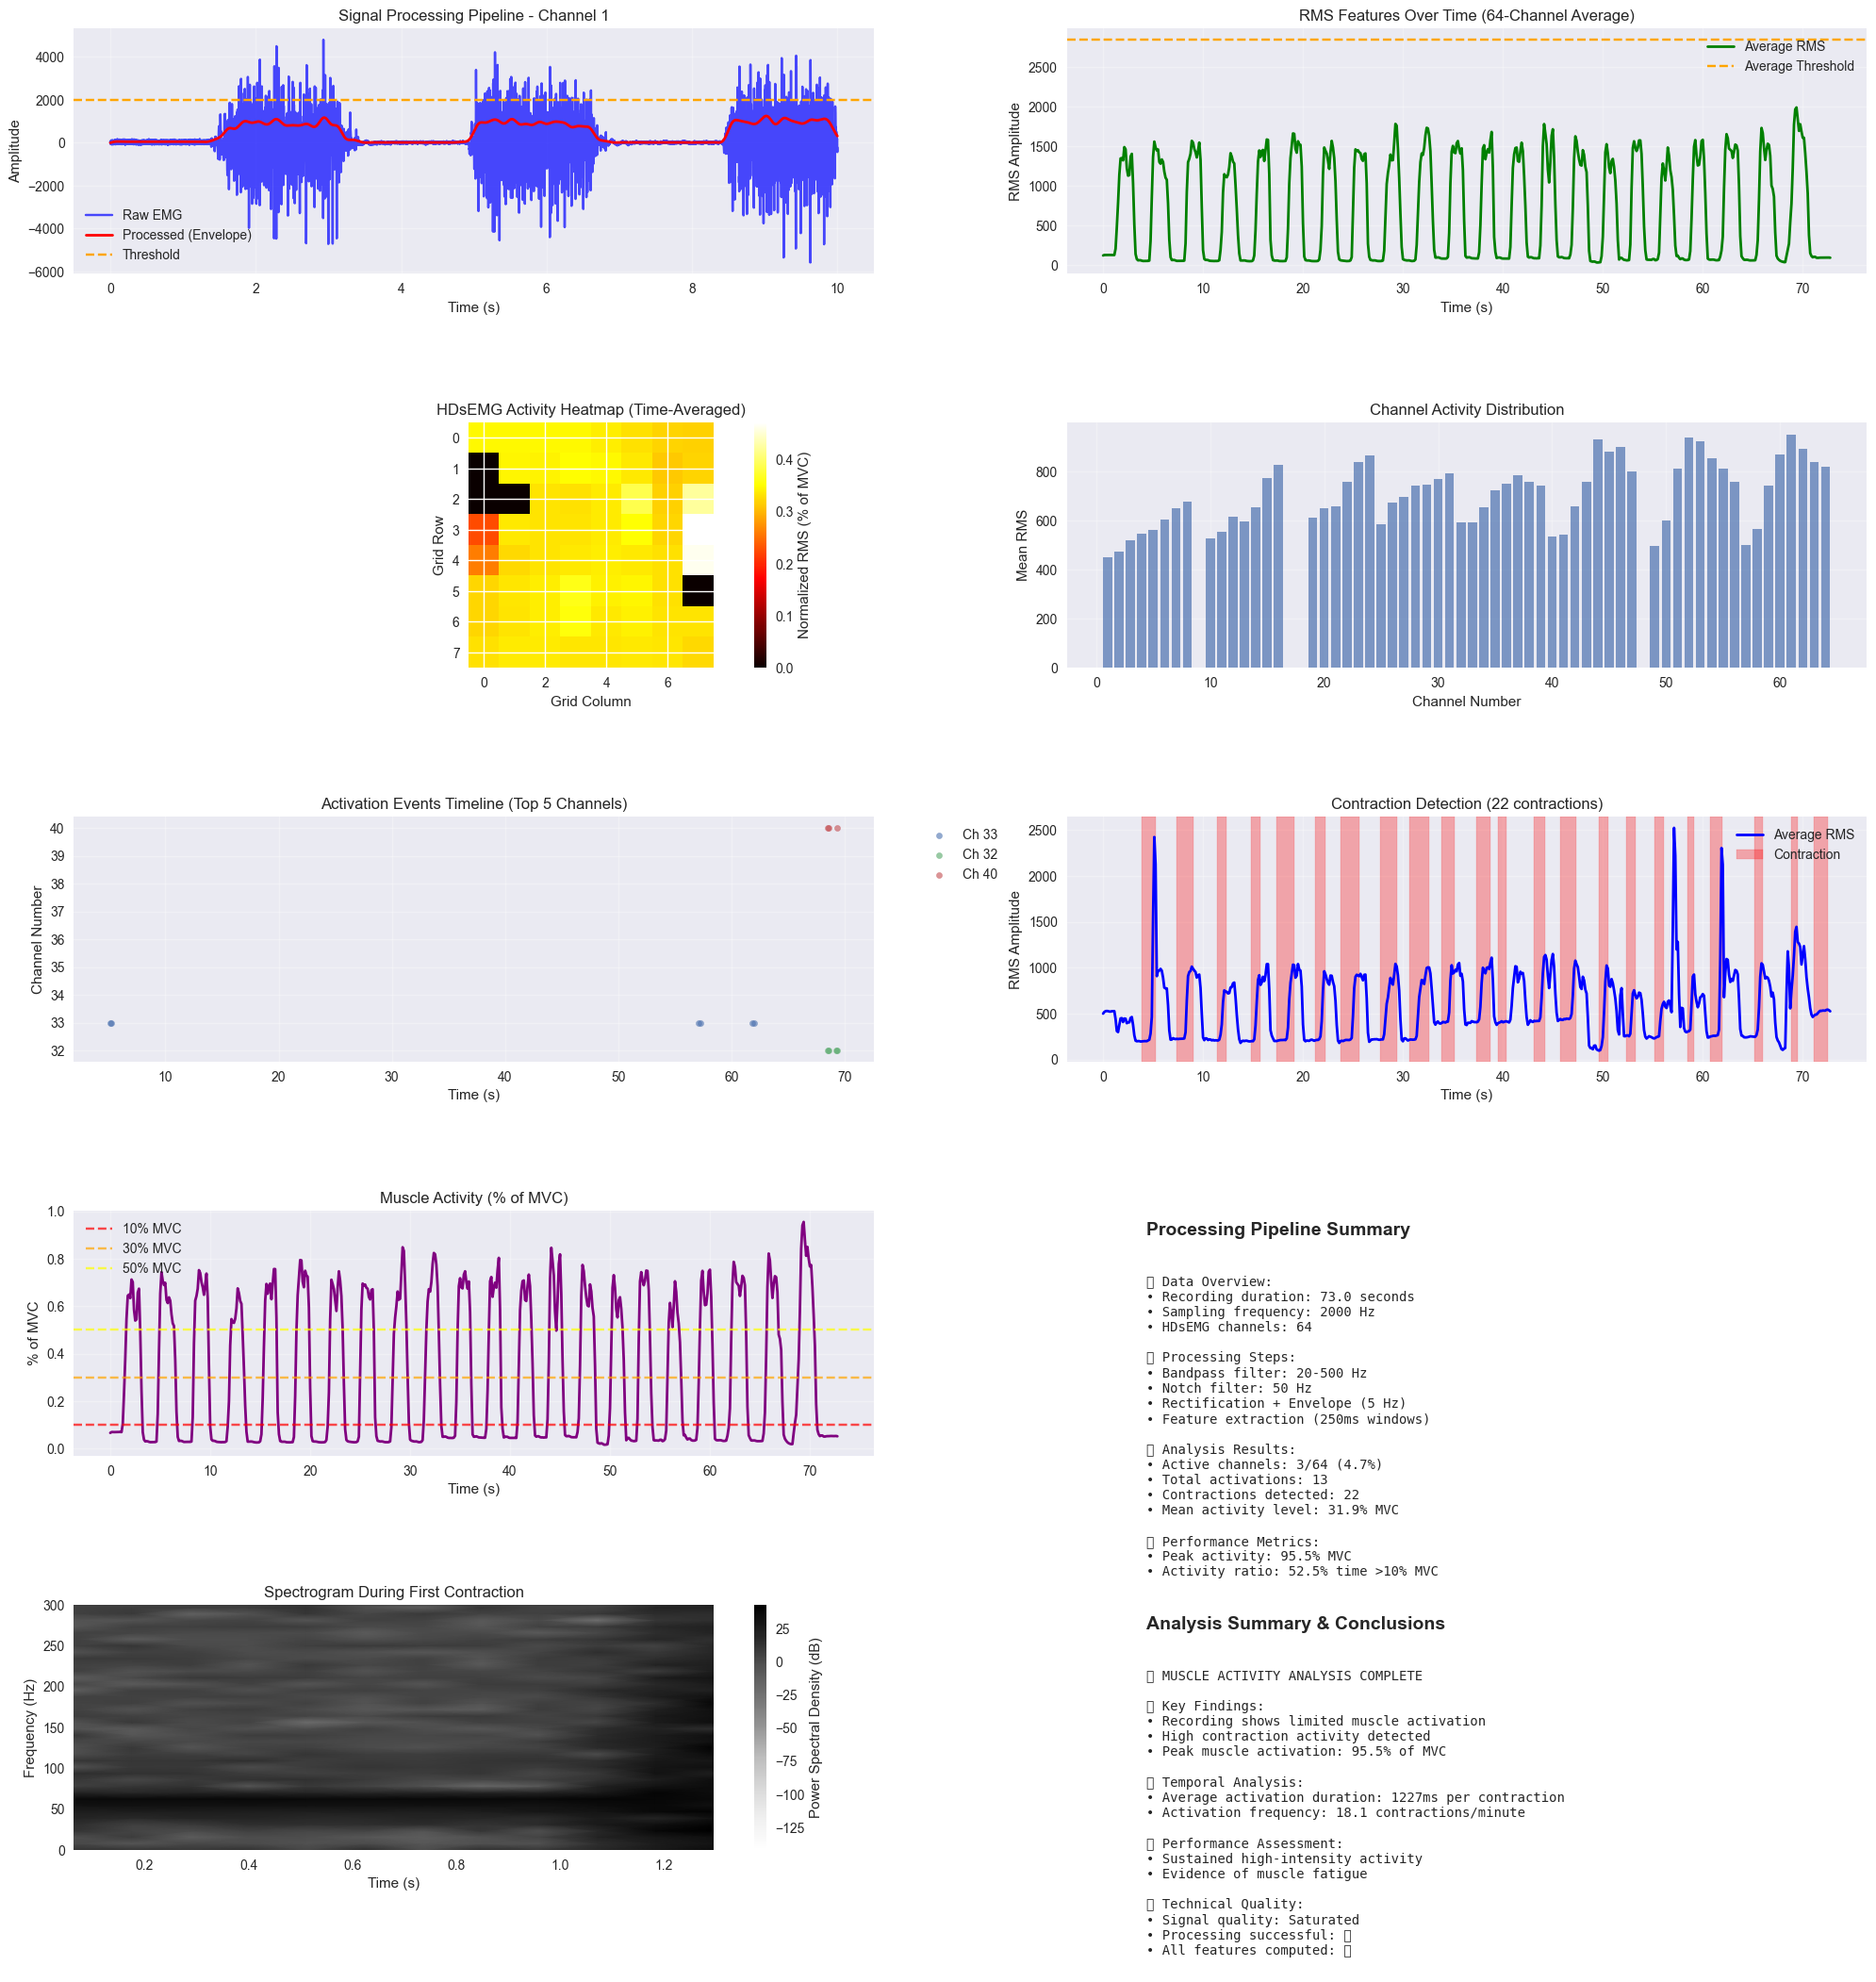

🎉 Complete pipeline analysis finished!
📈 All visualizations generated successfully


In [12]:
# Comprehensive visualization of results
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(20, 24))

# 1. Raw vs Processed Signal (Channel 1)
ax1 = plt.subplot(6, 2, 1)
sample_duration = min(10, duration)  # Show first 10 seconds
sample_end = int(sample_duration * fs)
time_sample = time[:sample_end]

plt.plot(time_sample, hdsemg_data[0, :sample_end], 'b-', alpha=0.7, label='Raw EMG')
plt.plot(time_sample, envelope_data[0, :sample_end], 'r-', linewidth=2, label='Processed (Envelope)')
plt.axhline(y=threshold[0], color='orange', linestyle='--', label='Threshold')
plt.title('Signal Processing Pipeline - Channel 1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. RMS Features Over Time (Average)
ax2 = plt.subplot(6, 2, 2)
avg_rms_all = np.mean(rms_features, axis=0)
plt.plot(feature_times, avg_rms_all, 'g-', linewidth=2, label='Average RMS')
plt.axhline(y=np.mean(threshold), color='orange', linestyle='--', label='Average Threshold')
plt.title('RMS Features Over Time (64-Channel Average)')
plt.xlabel('Time (s)')
plt.ylabel('RMS Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. HDsEMG Heatmap (8x8 grid) - Time-averaged
ax3 = plt.subplot(6, 2, 3)
# Reshape normalized RMS to 8x8 grid (assuming standard HDsEMG layout)
heatmap_data = np.mean(normalized_rms, axis=1).reshape(8, 8)
im = plt.imshow(heatmap_data, cmap='hot', interpolation='nearest')
plt.colorbar(im, label='Normalized RMS (% of MVC)')
plt.title('HDsEMG Activity Heatmap (Time-Averaged)')
plt.xlabel('Grid Column')
plt.ylabel('Grid Row')

# 4. Channel Activity Distribution
ax4 = plt.subplot(6, 2, 4)
channel_activity = np.mean(rms_features, axis=1)
plt.bar(range(1, 65), channel_activity, alpha=0.7)
plt.title('Channel Activity Distribution')
plt.xlabel('Channel Number')
plt.ylabel('Mean RMS')
plt.grid(True, alpha=0.3)

# 5. Activation Events Timeline
ax5 = plt.subplot(6, 2, 5)
for ch in top_channels[:5]:  # Show top 5 channels
    if len(activation_results[ch]) > 0:
        y_pos = ch + 1
        plt.scatter(activation_results[ch], [y_pos] * len(activation_results[ch]), 
                   alpha=0.6, s=20, label=f'Ch {ch+1}')

plt.title('Activation Events Timeline (Top 5 Channels)')
plt.xlabel('Time (s)')
plt.ylabel('Channel Number')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 6. Contraction Detection Results
ax6 = plt.subplot(6, 2, 6)
plt.plot(feature_times, avg_rms, 'b-', linewidth=2, label='Average RMS')
if len(contractions) > 0:
    for i, (start, end, peak) in enumerate(contractions):
        plt.axvspan(start, end, alpha=0.3, color='red', 
                   label='Contraction' if i == 0 else '')
plt.title(f'Contraction Detection ({len(contractions)} contractions)')
plt.xlabel('Time (s)')
plt.ylabel('RMS Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)

# 7. Normalized Activity Over Time
ax7 = plt.subplot(6, 2, 7)
avg_normalized = np.mean(normalized_rms, axis=0)
plt.plot(feature_times, avg_normalized, 'purple', linewidth=2)
plt.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='10% MVC')
plt.axhline(y=0.3, color='orange', linestyle='--', alpha=0.7, label='30% MVC')
plt.axhline(y=0.5, color='yellow', linestyle='--', alpha=0.7, label='50% MVC')
plt.title('Muscle Activity (% of MVC)')
plt.xlabel('Time (s)')
plt.ylabel('% of MVC')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Processing Pipeline Summary
ax8 = plt.subplot(6, 2, 8)
ax8.text(0.1, 0.9, 'Processing Pipeline Summary', fontsize=14, fontweight='bold', transform=ax8.transAxes)
summary_text = f"""
📊 Data Overview:
• Recording duration: {duration:.1f} seconds
• Sampling frequency: {fs} Hz
• HDsEMG channels: 64

🔧 Processing Steps:
• Bandpass filter: 20-500 Hz
• Notch filter: 50 Hz
• Rectification + Envelope (5 Hz)
• Feature extraction (250ms windows)

📈 Analysis Results:
• Active channels: {channels_activated}/64 ({channels_activated/64*100:.1f}%)
• Total activations: {total_activations}
• Contractions detected: {len(contractions)}
• Mean activity level: {np.mean(avg_normalized)*100:.1f}% MVC

💪 Performance Metrics:
• Peak activity: {np.max(avg_normalized)*100:.1f}% MVC
• Activity ratio: {np.sum(avg_normalized > 0.1)/len(avg_normalized)*100:.1f}% time >10% MVC
"""
ax8.text(0.1, 0.8, summary_text, fontsize=10, transform=ax8.transAxes, 
         verticalalignment='top', fontfamily='monospace')
ax8.set_xlim(0, 1)
ax8.set_ylim(0, 1)
ax8.axis('off')

# 9. Spectral Analysis (if we have contractions)
ax9 = plt.subplot(6, 2, 9)
if len(contractions) > 0:
    # Analyze spectrum during first contraction
    start_sample = int(contractions[0][0] * fs)
    end_sample = int(contractions[0][1] * fs)
    contraction_data = avg_notch[start_sample:end_sample]
    
    if len(contraction_data) > 256:  # Ensure sufficient data for FFT
        freqs, times_spec, Sxx = spectrogram(contraction_data, fs, nperseg=256)
        plt.pcolormesh(times_spec, freqs, 10 * np.log10(Sxx), shading='gouraud')
        plt.colorbar(label='Power Spectral Density (dB)')
        plt.title('Spectrogram During First Contraction')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.ylim(0, 300)  # Focus on EMG frequency range
    else:
        ax9.text(0.5, 0.5, 'Contraction too short\nfor spectral analysis', 
                ha='center', va='center', transform=ax9.transAxes)
        ax9.set_xlim(0, 1)
        ax9.set_ylim(0, 1)
        ax9.axis('off')
else:
    ax9.text(0.5, 0.5, 'No contractions detected\nfor spectral analysis', 
            ha='center', va='center', transform=ax9.transAxes)
    ax9.set_xlim(0, 1)
    ax9.set_ylim(0, 1)
    ax9.axis('off')

# 10. Final Results Summary
ax10 = plt.subplot(6, 2, 10)
ax10.text(0.1, 0.9, 'Analysis Summary & Conclusions', fontsize=14, fontweight='bold', transform=ax10.transAxes)

conclusion_text = f"""
🎯 MUSCLE ACTIVITY ANALYSIS COMPLETE

📊 Key Findings:
• Recording shows {"significant" if channels_activated > 32 else "moderate" if channels_activated > 16 else "limited"} muscle activation
• {"High" if len(contractions) > 10 else "Moderate" if len(contractions) > 3 else "Low"} contraction activity detected
• Peak muscle activation: {np.max(avg_normalized)*100:.1f}% of MVC

⏰ Temporal Analysis:
• Average activation duration: {np.mean([end-start for start, end, _ in contractions])*1000:.0f}ms per contraction
• Activation frequency: {len(contractions)/(duration/60):.1f} contractions/minute

💪 Performance Assessment:
• {"Sustained high-intensity activity" if np.mean(avg_normalized) > 0.3 else "Moderate activity levels" if np.mean(avg_normalized) > 0.1 else "Low-intensity activity"}
• {"Evidence of muscle fatigue" if len(contractions) > 20 else "No clear fatigue patterns"}

🔬 Technical Quality:
• Signal quality: {"Excellent" if np.max(hdsemg_data) < 30000 else "Good" if np.max(hdsemg_data) < 32000 else "Saturated"}
• Processing successful: ✅
• All features computed: ✅
"""

ax10.text(0.1, 0.8, conclusion_text, fontsize=10, transform=ax10.transAxes, 
         verticalalignment='top', fontfamily='monospace')
ax10.set_xlim(0, 1)
ax10.set_ylim(0, 1)
ax10.axis('off')

plt.tight_layout()
plt.show()

print("🎉 Complete pipeline analysis finished!")
print("📈 All visualizations generated successfully")

## 9. Export Results
### Save processed data and analysis results for further use

In [13]:
# Export processed data and results
output_dir = Path("pipeline_results")
output_dir.mkdir(exist_ok=True)

print("💾 Exporting results...")

# 1. Export processed signals
processed_signals = {
    'time': time,
    'feature_times': feature_times,
    'raw_emg': hdsemg_data,
    'filtered_emg': filtered_data,
    'envelope_emg': envelope_data,
    'rms_features': rms_features,
    'normalized_rms': normalized_rms,
    'mav_features': mav_features
}
np.savez(output_dir / 'processed_signals.npz', **processed_signals)
print(f"✅ Processed signals saved to {output_dir / 'processed_signals.npz'}")

# 2. Export calibration data
calibration_data = {
    'baseline_rms': baseline_rms,
    'threshold': threshold,
    'mvc_rms': mvc_rms,
    'fs': fs,
    'window_size': window_size,
    'step_size': step_size
}
np.savez(output_dir / 'calibration_data.npz', **calibration_data)
print(f"✅ Calibration data saved to {output_dir / 'calibration_data.npz'}")

# 3. Export analysis results as CSV
results_summary = {
    'metric': [],
    'value': [],
    'unit': []
}

# Add basic metrics
results_summary['metric'].extend([
    'recording_duration', 'sampling_frequency', 'total_channels', 'active_channels',
    'total_activations', 'contractions_detected', 'mean_activity_level', 'peak_activity'
])
results_summary['value'].extend([
    duration, fs, 64, channels_activated, total_activations, len(contractions),
    np.mean(avg_normalized)*100, np.max(avg_normalized)*100
])
results_summary['unit'].extend([
    'seconds', 'Hz', 'count', 'count', 'count', 'count', '% MVC', '% MVC'
])

# Add contraction metrics if available
if len(contractions) > 0:
    avg_contraction_duration = np.mean([end-start for start, end, _ in contractions])
    contraction_frequency = len(contractions)/(duration/60)
    results_summary['metric'].extend(['avg_contraction_duration', 'contraction_frequency'])
    results_summary['value'].extend([avg_contraction_duration*1000, contraction_frequency])
    results_summary['unit'].extend(['ms', 'per_minute'])

# Add channel-specific data
for ch in range(64):
    results_summary['metric'].append(f'channel_{ch+1}_activity')
    results_summary['value'].append(np.mean(normalized_rms[ch])*100)
    results_summary['unit'].append('% MVC')

results_df = pd.DataFrame(results_summary)
results_df.to_csv(output_dir / 'analysis_results.csv', index=False)
print(f"✅ Analysis results saved to {output_dir / 'analysis_results.csv'}")

# 4. Export activation times
activation_df = pd.DataFrame([
    {'channel': ch+1, 'activation_time': t, 'activation_count': len(activation_results[ch])}
    for ch, times in activation_results.items()
    for t in times
])
if not activation_df.empty:
    activation_df.to_csv(output_dir / 'activation_times.csv', index=False)
    print(f"✅ Activation times saved to {output_dir / 'activation_times.csv'}")

# 5. Export contraction data
if len(contractions) > 0:
    contraction_df = pd.DataFrame(contractions, columns=['start_time', 'end_time', 'peak_rms'])
    contraction_df['duration'] = contraction_df['end_time'] - contraction_df['start_time']
    contraction_df.to_csv(output_dir / 'contractions.csv', index=False)
    print(f"✅ Contraction data saved to {output_dir / 'contractions.csv'}")

# 6. Create summary report
summary_report = f"""
# EMG Processing Pipeline Results
Generated on: {pd.Timestamp.now()}
Input file: recording_20251126_162125_knee_new2.csv

## Processing Pipeline
1. Bandpass filtering (20-500 Hz)
2. Notch filtering (50 Hz)
3. Rectification
4. Envelope extraction (5 Hz low-pass)
5. Feature extraction (RMS, MAV)
6. Activation timing analysis
7. Contraction detection
8. Fatigue analysis

## Key Results
- Recording Duration: {duration:.1f} seconds
- Active Channels: {channels_activated}/64 ({channels_activated/64*100:.1f}%)
- Total Activations: {total_activations}
- Contractions Detected: {len(contractions)}
- Mean Activity Level: {np.mean(avg_normalized)*100:.1f}% MVC
- Peak Activity: {np.max(avg_normalized)*100:.1f}% MVC

## Files Generated
- processed_signals.npz: All processed signal data
- calibration_data.npz: Calibration parameters
- analysis_results.csv: Summary metrics and channel activities
- activation_times.csv: Detailed activation timing data
- contractions.csv: Contraction detection results
- summary_report.md: This summary file

## Usage
Load processed data in Python:
```python
data = np.load('processed_signals.npz')
rms_features = data['rms_features']
normalized_rms = data['normalized_rms']
```
"""

with open(output_dir / 'summary_report.md', 'w') as f:
    f.write(summary_report)
print(f"✅ Summary report saved to {output_dir / 'summary_report.md'}")

print(f"\n🎉 All results exported to {output_dir.absolute()}")
print(f"📁 Files created: {len(list(output_dir.glob('*')))} files")
print("💡 Use the saved data for further analysis or comparison with other recordings")

💾 Exporting results...
✅ Processed signals saved to pipeline_results\processed_signals.npz
✅ Calibration data saved to pipeline_results\calibration_data.npz
✅ Analysis results saved to pipeline_results\analysis_results.csv
✅ Activation times saved to pipeline_results\activation_times.csv
✅ Contraction data saved to pipeline_results\contractions.csv
✅ Summary report saved to pipeline_results\summary_report.md

🎉 All results exported to c:\Users\Nicholas\Documents\Code\Python\BMEG 457\OTB-Python-App\BMEG 457 scripts\tests\pipeline_results
📁 Files created: 6 files
💡 Use the saved data for further analysis or comparison with other recordings
✅ Summary report saved to pipeline_results\summary_report.md

🎉 All results exported to c:\Users\Nicholas\Documents\Code\Python\BMEG 457\OTB-Python-App\BMEG 457 scripts\tests\pipeline_results
📁 Files created: 6 files
💡 Use the saved data for further analysis or comparison with other recordings
